## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import AutoConfig, TFAutoModelForTokenClassification,AutoTokenizer

## function to Load sentences from a file 
*  where each line contains a word and its associated label.
*  Sentences are separated by empty lines or lines starting with '-DOCSTART-'

In [2]:
def load_sentences(filepath):

    final = []
    sentences = []

    with open(filepath, 'r') as f:

        for line in f.readlines():

            if line == '\n' or line.startswith('-DOCSTART-'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))

    return final

In [3]:
# Define the base directory path for data files
base_path = '../input/conll003-englishversion/'

# Load datasets from specified files
train_samples = load_sentences(base_path + 'train.txt')
test_samples = load_sentences(base_path + 'test.txt')
valid_samples = load_sentences(base_path + 'valid.txt')

# Extract unique labels from the dataset and sort them
labels = sorted({tag for sentence in train_samples 
                             for _, tag in sentence})

## here total have four NER types, LOC, MISC, ORG, PER, combine with the three location type, B,I,O. This task is a 9 classification task.
* O - word doesn’t correspond to any entity.
* B-PER/I-PER - word corresponds to the beginning of / is inside a person entity.
* B-ORG/I-ORG - word corresponds to the beginning of / is inside an organization entity.
* B-LOC/I-LOC - word corresponds to the beginning of / is inside a location entity.
* B-MISC/I-MISC - word corresponds to the beginning of / is inside a miscellaneous entity.

In [4]:
labels

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [5]:
num_labels = len(labels)

In [6]:
# Create a mapping from tag names to unique integer indices
tag_index = {tag: i for i, tag in enumerate(labels)}
print(tag_index)

{'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7, 'O': 8}


## Model

In [7]:
MODEL_NAME = 'bert-base-cased' 

# Load the configuration with the number of labels for classification
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels)

# Load the pre-trained RoBERTa model for token classification
model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME, config=config)

# Print the model summary
model.summary()


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  107719680 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  6921      
Total params: 107,726,601
Trainable params: 107,726,601
Non-trainable params: 0
_________________________________________________________________


## Tokenize

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

## Tokenize each token in the sample and create a list of (subtoken, tag) pairs

In [9]:
def tokenize_sample(sample):
    seq = [
               (subtoken, tag)
               for token, tag in sample
               for subtoken in tokenizer(token)['input_ids'][1:-1]
           ]
    # Add special tokens for start and end of the sequence
    return [(3, 'O')] + seq + [(4, 'O')]

## Preprocessing Samples

In [10]:
def preprocess(samples):
    # Tokenize each sample and compute the maximum sequence length
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

## Preprocessing and Preparing Data for Training, Testing, and Validation


In [11]:
X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

14041it [00:12, 1118.66it/s]
3453it [00:02, 1224.79it/s]
3250it [00:03, 1046.60it/s]


## Training

In [12]:
EPOCHS=5
BATCH_SIZE=8
LEARNING_RATE = 0.000001

optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(X_train,y_train,validation_data=(X_valid, y_valid), epochs=EPOCHS, 
                    batch_size=BATCH_SIZE)

Epoch 1/5
1756/1756 [==============================] - 386s 207ms/step - loss: 0.2920 - accuracy: 0.9281 - val_loss: 0.0671 - val_accuracy: 0.9809
Epoch 2/5
1756/1756 [==============================] - 361s 205ms/step - loss: 0.0510 - accuracy: 0.9850 - val_loss: 0.0342 - val_accuracy: 0.9903
Epoch 3/5
1756/1756 [==============================] - 360s 205ms/step - loss: 0.0295 - accuracy: 0.9913 - val_loss: 0.0241 - val_accuracy: 0.9929
Epoch 4/5
1756/1756 [==============================] - 360s 205ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.0195 - val_accuracy: 0.9944
Epoch 5/5
1756/1756 [==============================] - 360s 205ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 0.0157 - val_accuracy: 0.9955


## Training results

### Plotting Training and Validation Losses

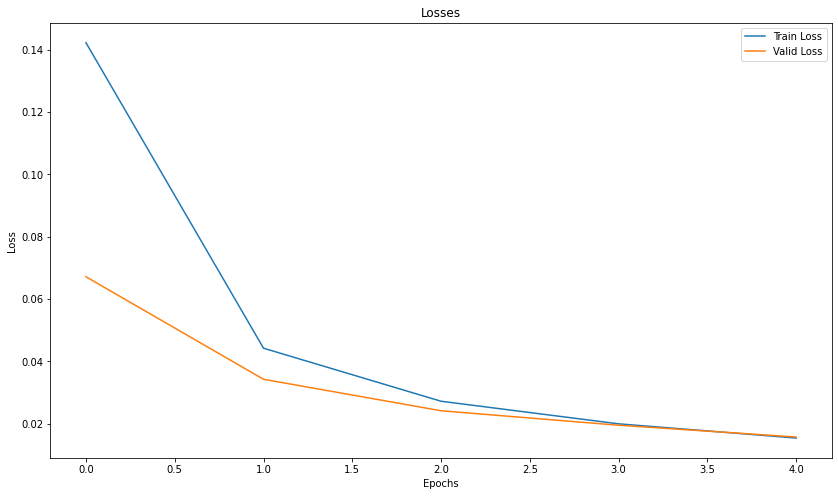

In [16]:
plt.figure(figsize=(14,8))
plt.title('Losses')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Plotting Training and Validation Accuracies


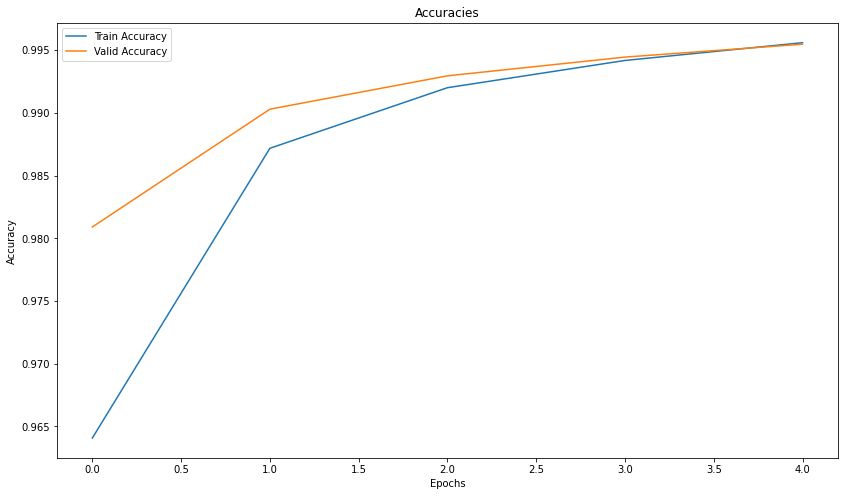

In [14]:
plt.figure(figsize=(14,8))
plt.title('Accuracies')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## test results

In [15]:
[loss, accuracy] = model.evaluate(X_test, y_test)
print("Loss:%1.3f, Accuracy:%1.3f" % (loss, accuracy))

108/108 [==============================] - 22s 177ms/step - loss: 0.0212 - accuracy: 0.9942
Loss:0.021, Accuracy:0.994
